In [12]:
#Description: This code defines and uses the function that can make electricity consumption reading predictions

#Author: Katie Roberts
#Dates: 16/04/21

In [10]:
#define the function that makes predictions
def predictions(synetica_data, meter_ID, building, start_predictions_timestamp, prediction_interval, end_predictions_timestamp, check, check_data):


    #import all libraries needed
    import pandas as pd
    from sklearn.metrics import mean_absolute_error
    import numpy as np
    import holidays
    import datetime
    from datetime import datetime
    import statistics
    import pickle
    #read the synetica data that includes the data needed for input to the model
    synetica=pd.read_csv(synetica_data) #read the synetica timeseries data
    synetica=synetica.drop(columns={'units', 'device_id'})#drop useless columns
    synetica=synetica.rename(columns={'name':'Meter_ID'})#rename the name column to Meter_ID
    #Read meter sensor information data
    meter_list=pd.read_csv('Synetica_meter_list.csv')
    meter_list=meter_list.drop(columns={'Unnamed: 6', 'class'})#drop useless columns 
    meter_list=meter_list.rename(columns={'Meter ID':'Meter_ID'})
    #merge the synetica and meter sensor information data based on the meter_id
    past_data= pd.merge(synetica, meter_list, how='inner', left_on='Meter_ID', right_on='Meter_ID')#join meter and time series data
    #select only the rows which include the data corresponding to the chosen meter id
    past_data=past_data.loc[(past_data['Meter_ID']==meter_ID)]
    #if there is limited data for the chosen meter notify the user that there is not enough input data for thge model to make predictions
    if past_data.shape[0] < 50:
        print('Inadequate previous data available')
    #if there is enough data proceed    
    else:

        past_data_df=past_data.reset_index()
        past_data_df['Day']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%A'))#Create a day of the week column
        past_data_df['Date']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))#create a date column
        past_data_df['Time']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%H:%M:%S'))#create a time column
        past_data_df['Date']=past_data_df['Date'].astype('str')#change the data type of the date column to string
        #create a column with the data and hour 
        past_data_df['Date_Hour']=past_data_df['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        #read the occupancy dataframe
        occ_df=pd.read_csv('occupancy_dataframe.csv')
        #select only the rows which include the chosen building
        build_occ=occ_df.loc[(occ_df['Building']==building)]
        #add the counts with the same timestamps in the case of multiple floors
        build_occ_total=build_occ.groupby(["time"])[['Associated Client Count', 'Authenticated Client Count']].sum()
        build_occ_df=pd.DataFrame(data=build_occ_total).reset_index()
        #create a date hour and minute number and take the average of the counts if the minute is rounded to the same number
        build_occ_df['Date_Hour']=build_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        build_occ_df['min']=build_occ_df['time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
        build_occ_df['min']=build_occ_df['min'].astype(int)
        build_occ_df['min']=round(build_occ_df['min']/10)*10
        build_occ_df=build_occ_df.groupby(['Date_Hour','min'], as_index=False)[['Associated Client Count', 'Authenticated Client Count']].mean()
        #create a minute column rounded to the nearest 10 minutes with int data type
        past_data_df['min']=past_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M'))
        past_data_df['min']=past_data_df['min'].astype(int)
        past_data_df['min']=round(past_data_df['min']/10)*10
        #merge the occupancy and synetica data based on the date, hour and minute rounded to the nearest 10 minutes
        past_data_with_occ=pd.merge(build_occ_df, past_data_df, left_on=['Date_Hour','min'], right_on = ['Date_Hour','min'], how='right')
        #read the weather data
        weather=pd.read_csv('LA14YW.csv')
        weather['Date_Hour']=weather['date_time'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H'))
        #merge the datasets based on the date and hour
        complete_past_data= pd.merge(weather, past_data_with_occ, how='right', left_on='Date_Hour', right_on='Date_Hour')
        #create float values of the timestamps
        complete_past_data["Year"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
        complete_past_data["Month"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
        complete_past_data["Day"] = complete_past_data['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)

        complete_past_data["hour"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        complete_past_data["minute"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        complete_past_data["second"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)

        complete_past_data["hour"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        complete_past_data["minute"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        complete_past_data["second"] = complete_past_data['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)
        #convert the sunrise time to datetime and extract the hour and minute
        complete_past_data["sunrise"]=pd.to_datetime(complete_past_data["sunrise"])
        complete_past_data["sunrise_hour"] = complete_past_data['sunrise'].dt.strftime('%H').astype(float)
        complete_past_data["sunrise_minute"] = complete_past_data['sunrise'].dt.strftime('%M').astype(float)
        #convert the sunset time to datetime and extract the hour and minute
        complete_past_data["sunset"]=pd.to_datetime(complete_past_data["sunset"])
        complete_past_data["sunset_hour"] = complete_past_data['sunset'].dt.strftime('%H').astype(float)
        complete_past_data["sunset_minute"] = complete_past_data['sunset'].dt.strftime('%M').astype(float)
        #since the weather data is only recorded every 3 hours there is a lot of missing data points that need to be filled
        #for weather data it can be assumed that the variables will not change too drastically over short periods of time
        #therefore the missing values can be filled with the most recent value
        #this is odne for all the weather variables and for the occupancy data
        complete_past_data['previous_mintempC'] = complete_past_data.groupby(['Meter Type'])['mintempC'].ffill()
        complete_past_data['previous_maxtempC'] = complete_past_data.groupby(['Meter Type'])['maxtempC'].ffill()
        complete_past_data['previous_totalSnow_cm'] = complete_past_data.groupby(['Meter Type'])['totalSnow_cm'].ffill()
        complete_past_data['previous_sunHour'] = complete_past_data.groupby(['Meter Type'])['sunHour'].ffill()
        complete_past_data['previous_uvIndex'] = complete_past_data.groupby(['Meter Type'])['uvIndex'].ffill()
        complete_past_data['previous_moon_illumination'] = complete_past_data.groupby(['Meter Type'])['moon_illumination'].ffill()
        complete_past_data['previous_sunrise_hour'] = complete_past_data.groupby(['Meter Type'])['sunrise_hour'].ffill()
        complete_past_data['previous_sunrise_minute'] = complete_past_data.groupby(['Meter Type'])['sunrise_hour'].ffill()
        complete_past_data['previous_sunset_hour'] = complete_past_data.groupby(['Meter Type'])['sunset_hour'].ffill()
        complete_past_data['previous_sunset_minute'] = complete_past_data.groupby(['Meter Type'])['sunset_minute'].ffill()
        complete_past_data['previous_DewPointC'] = complete_past_data.groupby(['Meter Type'])['DewPointC'].ffill()
        complete_past_data['previous_FeelsLikeC'] = complete_past_data.groupby(['Meter Type'])['FeelsLikeC'].ffill()
        complete_past_data['previous_HeatIndexC'] = complete_past_data.groupby(['Meter Type'])['HeatIndexC'].ffill()
        complete_past_data['previous_WindChillC'] = complete_past_data.groupby(['Meter Type'])['WindChillC'].ffill()
        complete_past_data['previous_WindGustKmph'] = complete_past_data.groupby(['Meter Type'])['WindGustKmph'].ffill()
        complete_past_data['previous_cloudcover'] = complete_past_data.groupby(['Meter Type'])['cloudcover'].ffill()
        complete_past_data['previous_humidity'] = complete_past_data.groupby(['Meter Type'])['humidity'].ffill()
        complete_past_data['previous_precipMM'] = complete_past_data.groupby(['Meter Type'])['precipMM'].ffill()
        complete_past_data['previous_pressure'] = complete_past_data.groupby(['Meter Type'])['pressure'].ffill()
        complete_past_data['previous_tempC'] = complete_past_data.groupby(['Meter Type'])['tempC'].ffill()
        complete_past_data['previous_visibility'] = complete_past_data.groupby(['Meter Type'])['visibility'].ffill()
        complete_past_data['previous_winddirDegree'] = complete_past_data.groupby(['Meter Type'])['winddirDegree'].ffill()
        complete_past_data['previous_mintempC'] = complete_past_data.groupby(['Meter Type'])['mintempC'].ffill()
        complete_past_data['previous_windspeedKmph'] = complete_past_data.groupby(['Meter Type'])['windspeedKmph'].ffill()
        complete_past_data['previous_Associated Client Count'] = complete_past_data.groupby(['Meter Type'])['Associated Client Count'].ffill()
        complete_past_data['previous_Authenticated Client Count'] = complete_past_data.groupby(['Meter Type'])['Authenticated Client Count'].ffill()

        #create the dataframe of the future timestamps that predictions are required for
        future_data=[] #create an empty list
        #create a list of dates starting and ending at the specified dates with the specified intervals
        for i in range(0, int(((end_predictions_timestamp-start_predictions_timestamp)/prediction_interval)+1)):
            future_data.append(start_predictions_timestamp+(prediction_interval*i))
        #create a dataframe from the list
        future_data_df=pd.DataFrame(future_data, columns=['future_date'])
        #find the most recent date that recorded data is available from
        last_past_date=complete_past_data.timestamp[complete_past_data.index.max()]
        #calculate the maximum forecast horizon between the most recent recorded data and the last future timestamp required
        maximum_forecast_horizon=pd.to_datetime(future_data_df.future_date[future_data_df.index.max()])-pd.to_datetime(last_past_date)

        future_data_df['Day']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%A'))#Create a day of the week column
        future_data_df['Date']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))#Create a date column
        future_data_df['Time']=future_data_df['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%H:%M:%S'))#create a time column
        future_data_df['Date']=future_data_df['Date'].astype('str')#change the datatype of the date column to string
        #extract the Year, month, day, hour, minute and second from the future dates and change them to data type floats
        future_data_df["Year"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y')).astype(float)
        future_data_df["Month"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%m')).astype(float)
        future_data_df["Day"] = future_data_df['Date'].apply(lambda x:pd.Timestamp(x).strftime('%d')).astype(float)
        future_data_df["hour"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%H')).astype(float)
        future_data_df["minute"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%M')).astype(float)
        future_data_df["second"] = future_data_df['Time'].apply(lambda x:pd.Timestamp(x).strftime('%S')).astype(float)

        #create term dates calander
        
        # create a complete list of dates starting and ending at the specified future dates
        rng = pd.date_range(start_predictions_timestamp, end_predictions_timestamp, freq='D') 
        

        
        #rng = pd.date_range('2018-01-11', periods=1200, freq='D')
        term_dates = pd.DataFrame({'Date': rng}) #create a dataframe from the above list
        term=[] #create an empty list
        term_as_int=[]#create an empty list
        welcome_week_int=0 #assign a value of 0 to the welcome week
        term_int=1 #assign a value of 1 to term times
        holiday_int=2 #assign a value of 2 to holiday time

        #determine the term type for each of the dates in the future dates data frame 
        # term dates from the university calander will need to be added to this as time goes on
        for i in range(0, (term_dates.index.max()+1)):
            if np.datetime64('2018-10-01')<=term_dates.Date[i]<=np.datetime64('2018-10-07') or np.datetime64('2019-09-30')<=term_dates.Date[i]<np.datetime64('2019-10-05') or np.datetime64('2020-09-21')<=term_dates.Date[i]<=np.datetime64('2020-10-02'):
                term.append('welcome_week')
                term_as_int.append(welcome_week_int)
            elif np.datetime64('2018-10-07')<term_dates.Date[i]<=np.datetime64('2018-12-14') or np.datetime64('2019-10-05')<=term_dates.Date[i]<=np.datetime64('2019-12-14') or np.datetime64('2020-10-02')<=term_dates.Date[i]<=np.datetime64('2020-12-11'):
                term.append('michelmas_term')
                term_as_int.append(term_int)       
            elif np.datetime64('2017-12-15')<=term_dates.Date[i]<=np.datetime64('2018-01-15') or np.datetime64('2018-12-14')<term_dates.Date[i]<np.datetime64('2019-01-14') or np.datetime64('2019-12-14')<term_dates.Date[i]<np.datetime64('2020-01-13') or np.datetime64('2020-12-11')<=term_dates.Date[i]<=np.datetime64('2021-01-08'):
                term.append('Christmas_break')
                term_as_int.append(holiday_int)
            elif np.datetime64('2018-01-15')<term_dates.Date[i]<=np.datetime64('2018-03-30') or np.datetime64('2019-01-14')<=term_dates.Date[i]<=np.datetime64('2019-03-29') or np.datetime64('2020-01-13')<=term_dates.Date[i]<=np.datetime64('2020-03-20') or np.datetime64('2021-01-08')<=term_dates.Date[i]<=np.datetime64('2021-03-19'):
                term.append('lent_term')
                term_as_int.append(term_int)
            elif np.datetime64('2018-03-30')<term_dates.Date[i]<np.datetime64('2018-04-23') or np.datetime64('2019-03-29')<=term_dates.Date[i]<np.datetime64('2019-04-29') or np.datetime64('2020-03-20')<term_dates.Date[i]<np.datetime64('2020-04-20') or np.datetime64('2021-03-19')<term_dates.Date[i]<np.datetime64('2021-04-16'):
                term.append('Easter_break')
                term_as_int.append(holiday_int)
            elif np.datetime64('2018-04-23')<=term_dates.Date[i]<=np.datetime64('2018-06-29') or np.datetime64('2019-04-29')<=term_dates.Date[i]<=np.datetime64('2019-06-28') or np.datetime64('2020-04-20')<=term_dates.Date[i]<=np.datetime64('2020-06-26') or  np.datetime64('2021-04-16')<=term_dates.Date[i]<=np.datetime64('2025-06-25'):
                term.append('summer_term')
                term_as_int.append(term_int)
            elif np.datetime64('2018-06-29')<term_dates.Date[i]<=np.datetime64('2018-10-01') or np.datetime64('2019-06-28')<term_dates.Date[i]<=np.datetime64('2019-09-30') or np.datetime64('2020-06-26')<term_dates.Date[i]<np.datetime64('2020-09-21'):
                term.append('summer_break')
                term_as_int.append(holiday_int)
            else:
                term.append(None)

        #add the lists to the term_dates data frame
        term_dates['Term']=term              
        term_dates['Term_as_int']=term_as_int
        term_dates["Date"]=pd.to_datetime(term_dates["Date"])#ensure the date column has data type datetime
        #change the date column ot only include the date and not the time
        term_dates['Date']=term_dates['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d')) 

        #get the UK bank holidays from the holidays library
        uk_holidays=holidays.UnitedKingdom()
        
        future_holidaydf=[] #create an empty list
        #determine the uk bankholidays on each of the dates in the specified future dates
        for i in range((future_data_df.index.min()), (future_data_df.index.max()+1)):
            date=str(future_data_df.Date[i])#get the date as an integer at each row of the future data data frame 
            holiday=uk_holidays.get(date) #determine the bank holiday at each date
            future_holidaydf.append(holiday) #add the holiday to the holiday list

        future_data_df['Holiday']=future_holidaydf # add the holiday list as a column in the future data data frame

        #create a type of day column where 0=workday, 1=weekend, 2=bank holiday
        f_day_type_int=[]
        f_day_type=[]
        bank_holiday=2
        weekend=1
        weekday=0

        #for each row in the future data data frame determine the type of day and the integer associated with this
        for i in range((future_data_df.index.min()), (future_data_df.index.max()+1)):
            #if the holiday is any of the bank holidays in England then the day type is bank holiday
            if (future_data_df['Holiday'][i]=="New Year's Day" or future_data_df['Holiday'][i]== "Good Friday" 
                or future_data_df['Holiday'][i]== "Easter Monday [England, Wales, Northern Ireland]" 
                or future_data_df['Holiday'][i]== "May Day" or future_data_df['Holiday'][i]=="Spring Bank Holiday" 
                or future_data_df['Holiday'][i]=="Late Summer Bank Holiday [England, Wales, Northern Ireland]" 
                or future_data_df['Holiday'][i]== "Christmas Day" or future_data_df['Holiday'][i]== "Boxing Day" 
                or future_data_df['Holiday'][i]=="Boxing Day (Observed)" ):
                
                f_day_type_int.append(bank_holiday)
                f_day_type.append('Bank_holiday')
                
            #if the day isn't a bank holiday whether it is a weekday or weekend is determined
            else:
                if future_data_df.Day[i]=='Saturday' or future_data_df.Day[i]=='Sunday':
                    f_day_type_int.append(weekend)
                    f_day_type.append('Weekend')
                else:
                    f_day_type_int.append(weekday)
                    f_day_type.append('Weekday')
        #the lists are added to the future data data frame
        future_data_df['Day_type_as_int']=f_day_type_int
        future_data_df['Day_type']=f_day_type
        #the future data and term dates data frame are merged to complete the future data
        complete_future_data= pd.merge(future_data_df, term_dates, how='inner', left_on='Date', right_on='Date')
        #the features that can be used as inputs to the model are used to create a data frame 
        input_future_data=complete_future_data[['Day', 'Day_type_as_int', 'Year', 'Month', 'hour', 'minute', 'Term_as_int']]
        
        #the features from the past recorded data are chosen
        past_features=['timestamp','reading','previous_maxtempC','previous_mintempC','previous_totalSnow_cm',
                    'previous_sunHour','previous_uvIndex','previous_moon_illumination','previous_sunrise_hour','previous_sunrise_minute',
                    'previous_sunset_hour','previous_sunset_minute','previous_DewPointC','previous_FeelsLikeC','previous_HeatIndexC','previous_WindChillC',
                    'previous_WindGustKmph','previous_cloudcover','previous_humidity','previous_precipMM','previous_pressure',
                    'previous_tempC','previous_visibility','previous_winddirDegree','previous_windspeedKmph',
                    'previous_Associated Client Count','previous_Authenticated Client Count']
        #another data frame with the features of the past data is created
        complete_past_data=complete_past_data[past_features]
        
        complete_future_data['future_date']=complete_future_data['future_date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
        
        #the previous day and week averages of the past recorded data are determined and added to the input future data data frame 
        day_avg_reading=statistics.mean(complete_past_data.reading[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_reading'] = pd.Series([day_avg_reading for x in range(len(input_future_data.index))])
        week_avg_reading=statistics.mean(complete_past_data.reading[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_reading'] = pd.Series([week_avg_reading for x in range(len(input_future_data.index))]) 

        day_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_maxtemp'] = pd.Series([day_avg_maxtemp for x in range(len(input_future_data.index))])
        week_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_maxtemp'] = pd.Series([week_avg_maxtemp for x in range(len(input_future_data.index))])

        day_avg_mintemp=statistics.mean(complete_past_data.previous_mintempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_mintemp'] = pd.Series([day_avg_mintemp for x in range(len(input_future_data.index))])
        week_avg_mintemp=statistics.mean(complete_past_data.previous_mintempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_mintemp'] = pd.Series([week_avg_mintemp for x in range(len(input_future_data.index))])

        day_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_maxtemp'] = pd.Series([day_avg_maxtemp for x in range(len(input_future_data.index))])
        week_avg_maxtemp=statistics.mean(complete_past_data.previous_maxtempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_maxtemp'] = pd.Series([week_avg_maxtemp for x in range(len(input_future_data.index))])

        day_avg_snow=statistics.mean(complete_past_data.previous_totalSnow_cm[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_snow'] = pd.Series([day_avg_snow for x in range(len(input_future_data.index))])
        week_avg_snow=statistics.mean(complete_past_data.previous_totalSnow_cm[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_snow'] = pd.Series([week_avg_snow for x in range(len(input_future_data.index))])

        day_avg_sunhour=statistics.mean(complete_past_data.previous_sunHour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunhour'] = pd.Series([day_avg_sunhour for x in range(len(input_future_data.index))])
        week_avg_sunhour=statistics.mean(complete_past_data.previous_sunHour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunhour'] = pd.Series([week_avg_sunhour for x in range(len(input_future_data.index))])

        day_avg_uvindex=statistics.mean(complete_past_data.previous_uvIndex[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_uvindex'] = pd.Series([day_avg_uvindex for x in range(len(input_future_data.index))])
        week_avg_uvindex=statistics.mean(complete_past_data.previous_uvIndex[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_uvindex'] = pd.Series([week_avg_uvindex for x in range(len(input_future_data.index))])

        day_avg_moonillumination=statistics.mean(complete_past_data.previous_moon_illumination[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_moonillumination'] = pd.Series([day_avg_moonillumination for x in range(len(input_future_data.index))])
        week_avg_moonillumination=statistics.mean(complete_past_data.previous_moon_illumination[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_moonillumination'] = pd.Series([week_avg_moonillumination for x in range(len(input_future_data.index))])

        day_avg_sunrise_hr=statistics.mean(complete_past_data.previous_sunrise_hour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunrise_hr'] = pd.Series([day_avg_sunrise_hr for x in range(len(input_future_data.index))])
        week_avg_sunrise_hr=statistics.mean(complete_past_data.previous_sunrise_hour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunrise_hr'] = pd.Series([week_avg_sunrise_hr for x in range(len(input_future_data.index))])

        day_avg_sunrise_min=statistics.mean(complete_past_data.previous_sunrise_minute[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunrise_min'] = pd.Series([day_avg_sunrise_min for x in range(len(input_future_data.index))])
        week_avg_sunrise_min=statistics.mean(complete_past_data.previous_sunrise_minute[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunrise_min'] = pd.Series([week_avg_sunrise_min for x in range(len(input_future_data.index))])

        day_avg_sunset_hr=statistics.mean(complete_past_data.previous_sunset_hour[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunset_hr'] = pd.Series([day_avg_sunset_hr for x in range(len(input_future_data.index))])
        week_avg_sunset_hr=statistics.mean(complete_past_data.previous_sunset_hour[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunset_hr'] = pd.Series([week_avg_sunset_hr for x in range(len(input_future_data.index))])

        day_avg_sunset_min=statistics.mean(complete_past_data.previous_sunset_minute[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_sunset_min'] = pd.Series([day_avg_sunset_min for x in range(len(input_future_data.index))])
        week_avg_sunset_min=statistics.mean(complete_past_data.previous_sunset_minute[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_sunset_min'] = pd.Series([week_avg_sunset_min for x in range(len(input_future_data.index))])

        day_avg_dewpoint=statistics.mean(complete_past_data.previous_DewPointC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_dewpoint'] = pd.Series([day_avg_dewpoint for x in range(len(input_future_data.index))])
        week_avg_dewpoint=statistics.mean(complete_past_data.previous_DewPointC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_dewpoint'] = pd.Series([week_avg_dewpoint for x in range(len(input_future_data.index))])

        day_avg_feelslike=statistics.mean(complete_past_data.previous_FeelsLikeC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_feelslike'] = pd.Series([day_avg_feelslike for x in range(len(input_future_data.index))])
        week_avg_feelslike=statistics.mean(complete_past_data.previous_FeelsLikeC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_feelslike'] = pd.Series([week_avg_feelslike for x in range(len(input_future_data.index))])

        day_avg_heatindex=statistics.mean(complete_past_data.previous_HeatIndexC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_heatindex'] = pd.Series([day_avg_heatindex for x in range(len(input_future_data.index))])
        week_avg_heatindex=statistics.mean(complete_past_data.previous_HeatIndexC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_heatindex'] = pd.Series([week_avg_heatindex for x in range(len(input_future_data.index))])

        day_avg_windchill=statistics.mean(complete_past_data.previous_WindChillC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windchill'] = pd.Series([day_avg_windchill for x in range(len(input_future_data.index))])
        week_avg_windchill=statistics.mean(complete_past_data.previous_WindChillC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windchill'] = pd.Series([week_avg_windchill for x in range(len(input_future_data.index))])

        day_avg_windgust=statistics.mean(complete_past_data.previous_WindGustKmph[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windgust'] = pd.Series([day_avg_windgust for x in range(len(input_future_data.index))])
        week_avg_windgust=statistics.mean(complete_past_data.previous_WindGustKmph[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windgust'] = pd.Series([week_avg_windgust for x in range(len(input_future_data.index))])

        day_avg_cloud=statistics.mean(complete_past_data.previous_cloudcover[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_cloud'] = pd.Series([day_avg_cloud for x in range(len(input_future_data.index))])
        week_avg_cloud=statistics.mean(complete_past_data.previous_cloudcover[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_cloud'] = pd.Series([week_avg_cloud for x in range(len(input_future_data.index))])

        day_avg_humidity=statistics.mean(complete_past_data.previous_humidity[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_humidity'] = pd.Series([day_avg_humidity for x in range(len(input_future_data.index))])
        week_avg_humidity=statistics.mean(complete_past_data.previous_humidity[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_humidity'] = pd.Series([week_avg_humidity for x in range(len(input_future_data.index))])

        day_avg_precip=statistics.mean(complete_past_data.previous_precipMM[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_precip'] = pd.Series([day_avg_precip for x in range(len(input_future_data.index))])
        week_avg_precip=statistics.mean(complete_past_data.previous_precipMM[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_precip'] = pd.Series([week_avg_precip for x in range(len(input_future_data.index))])

        day_avg_pressure=statistics.mean(complete_past_data.previous_pressure[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_pressure'] = pd.Series([day_avg_pressure for x in range(len(input_future_data.index))])
        week_avg_pressure=statistics.mean(complete_past_data.previous_pressure[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_pressure'] = pd.Series([week_avg_pressure for x in range(len(input_future_data.index))])

        day_avg_temp=statistics.mean(complete_past_data.previous_tempC[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_temp'] = pd.Series([day_avg_temp for x in range(len(input_future_data.index))])
        week_avg_temp=statistics.mean(complete_past_data.previous_tempC[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_temp'] = pd.Series([week_avg_temp for x in range(len(input_future_data.index))])

        day_avg_visibility=statistics.mean(complete_past_data.previous_visibility[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_visibility'] = pd.Series([day_avg_visibility for x in range(len(input_future_data.index))])
        week_avg_visibility=statistics.mean(complete_past_data.previous_visibility[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_visibility'] = pd.Series([week_avg_visibility for x in range(len(input_future_data.index))])

        day_avg_winddir=statistics.mean(complete_past_data.previous_winddirDegree[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_winddir'] = pd.Series([day_avg_winddir for x in range(len(input_future_data.index))])
        week_avg_winddir=statistics.mean(complete_past_data.previous_winddirDegree[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_winddir'] = pd.Series([week_avg_winddir for x in range(len(input_future_data.index))])

        day_avg_windspeed=statistics.mean(complete_past_data.previous_windspeedKmph[(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_windspeed'] = pd.Series([day_avg_windspeed for x in range(len(input_future_data.index))])
        week_avg_windspeed=statistics.mean(complete_past_data.previous_windspeedKmph[(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_windspeed'] = pd.Series([week_avg_windspeed for x in range(len(input_future_data.index))])

        day_avg_as_client=statistics.mean(complete_past_data['previous_Associated Client Count'][(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_as_client'] = pd.Series([day_avg_as_client for x in range(len(input_future_data.index))])
        week_avg_as_client=statistics.mean(complete_past_data['previous_Associated Client Count'][(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_as_client'] = pd.Series([week_avg_as_client for x in range(len(input_future_data.index))])

        day_avg_auth_client=statistics.mean(complete_past_data['previous_Authenticated Client Count'][(complete_past_data.index.max()-144):(complete_past_data.index.max())])
        input_future_data['day_avg_auth_client'] = pd.Series([day_avg_auth_client for x in range(len(input_future_data.index))])
        week_avg_auth_client=statistics.mean(complete_past_data['previous_Authenticated Client Count'][(complete_past_data.index.max()-1008):(complete_past_data.index.max())])
        input_future_data['week_avg_auth_client'] = pd.Series([week_avg_auth_client for x in range(len(input_future_data.index))])

        #it is determined whether there is occupancy data available
        #if there is not it is removed from the features
        if (input_future_data['week_avg_as_client'].isnull().any() == True):
            features=['day_avg_reading', 'week_avg_reading', 'hour',
              'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
              'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
              'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
              'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
              'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
              'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
              'day_avg_uvindex', 'day_avg_sunhour',
              'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
              'week_avg_sunrise_min' ,'Day_type_as_int', 
              'Month', 'Day','minute', 'Term_as_int', 'Year']
        else:

            features=['day_avg_reading', 'week_avg_reading', 'hour',
              'week_avg_sunset_hr', 'day_avg_sunset_hr', 'week_avg_dewpoint',
              'week_avg_windchill', 'week_avg_feelslike', 'week_avg_heatindex',
              'week_avg_temp', 'week_avg_mintemp', 'day_avg_mintemp',
              'week_avg_maxtemp', 'week_avg_uvindex', 'day_avg_windchill',
              'day_avg_feelslike', 'day_avg_heatindex', 'day_avg_temp',
              'day_avg_dewpoint', 'week_avg_sunhour', 'day_avg_maxtemp',
              'day_avg_uvindex', 'day_avg_sunhour',
              'day_avg_sunrise_hr', 'day_avg_sunrise_min', 'week_avg_sunrise_hr',
              'week_avg_sunrise_min' ,'day_avg_as_client','week_avg_as_client',
              'day_avg_auth_client','week_avg_auth_client','Day_type_as_int', 
              'Month', 'Day','minute', 'Term_as_int', 'Year']

        #the input to model data frame is created from the features above
        input_to_model=input_future_data[features]
        input_to_model=input_to_model.fillna(0) #used in case any data points are missing so that the model can still be used
        
        #the correct model is chosen depending on the forecasting horizon and whether there is occupancy data available
        if input_future_data.week_avg_as_client.isnull().any()==True :
            if maximum_forecast_horizon/'00:10:00' < 5:
                model=pickle.load(open('forest_model1no.sav', 'rb'))
            elif 5 < maximum_forecast_horizon/'00:10:00' < 30:
                model=pickle.load(open('forest_model2no.sav', 'rb'))
            elif 30 < maximum_forecast_horizon/'00:10:00' < 70:
                model=pickle.load(open('forest_model3no.sav', 'rb'))
            elif 70 < maximum_forecast_horizon/'00:10:00' < 110:
                model=pickle.load(open('forest_model4no.sav', 'rb'))
            elif 110 < maximum_forecast_horizon/'00:10:00' < 160:
                model=pickle.load(open('forest_model5no.sav', 'rb'))
            elif 160 < maximum_forecast_horizon/'00:10:00' < 240:
                model=pickle.load(open('forest_model6no.sav', 'rb'))
            elif 240 < maximum_forecast_horizon/'00:10:00' > 310:
                model=pickle.load(open('forest_model7no.sav', 'rb'))
            elif 310 < maximum_forecast_horizon/'00:10:00' < 390:
                model=pickle.load(open('forest_model8no.sav', 'rb'))
            elif 390 < maximum_forecast_horizon/'00:10:00' :
                model=pickle.load(open('forest_model9no.sav', 'rb'))

        else:
            if maximum_forecast_horizon/'00:10:00' < 5:
                model=pickle.load(open('forest_model1.sav', 'rb'))
            elif 5 < maximum_forecast_horizon/'00:10:00' < 30:
                model=pickle.load(open('forest_model2.sav', 'rb'))
            elif 30 < maximum_forecast_horizon/'00:10:00' < 70:
                model=pickle.load(open('forest_model3.sav', 'rb'))
            elif 70 < maximum_forecast_horizon/'00:10:00' < 110:
                model=pickle.load(open('forest_model4.sav', 'rb'))
            elif 110 < maximum_forecast_horizon/'00:10:00' < 160:
                model=pickle.load(open('forest_model5.sav', 'rb'))
            elif 160 < maximum_forecast_horizon/'00:10:00' < 240:
                model=pickle.load(open('forest_model6.sav', 'rb'))
            elif 240 < maximum_forecast_horizon/'00:10:00' > 310:
                model=pickle.load(open('forest_model7.sav', 'rb'))
            elif 310 < maximum_forecast_horizon/'00:10:00' < 390:
                model=pickle.load(open('forest_model8.sav', 'rb'))
            elif 390 < maximum_forecast_horizon/'00:10:00' :
                model=pickle.load(open('forest_model9.sav', 'rb'))
                
        #predictions are made by the model
        reading_predictions=model.predict(input_to_model)
        #a data frame is created from the predictions
        predictions_df=pd.DataFrame(reading_predictions, columns=['reading_predictions'])
        #a data frame of only the future dates specified is created
        future_preds_df=future_data_df[['future_date']]
        future_preds_df=future_preds_df.reset_index(drop=True)
        #the predicted readings are added to the future dates data frame as they match
        future_preds_df['predicted_reading']=predictions_df['reading_predictions']

        
        import matplotlib.pyplot as plt
        past_data=past_data.reset_index(drop=True)
        #the last portion of the past recorded data is chosen
        small_past=past_data[(past_data.index.max()-50):past_data.index.max()]
        small_past.timestamp=pd.to_datetime(small_past.timestamp, format='%Y-%m-%d %H:%M:%S')

        future_preds_df.future_date=pd.to_datetime(future_preds_df.future_date, format='%Y-%m-%d %H:%M:%S')
        
        #if it is required that the predictions are to be plotted against the recorded readings 
        if check== True:
            real=pd.read_csv(check_data)#the data containing the recorded readings is read
            real=real.loc[(real['name']==meter_ID)]# the data for the specified meter is chosen
            real.timestamp=pd.to_datetime(real.timestamp, format='%Y-%m-%d %H:%M:%S')
            #the dataframe with the predictions and the one with the real readings are merged
            check=pd.merge(future_preds_df, real, how='left', left_on='future_date', right_on='timestamp')
            #the date is chosen as the x variable
            x=check['future_date']
            tickx=x.astype(str)
            labels=tickx
            plt.figure(figsize=(25, 10))

            plt.xticks(rotation='vertical')

            plt.plot(x, check['reading'], c='green')# the real recorded readings are plotted

            plt.plot(x, check['predicted_reading'], c='red')#the predicted readings are plotted
            #the small portion of the past data is plotted
            plt.plot(small_past.timestamp[10:(small_past.index.max()-10)], small_past.reading[10:(small_past.index.max()-10)], c='blue')
            plt.xlabel('Date time')
            plt.ylabel('Reading')
            plt.legend(['Actual readings', 'predicted readings', 'past readings'])
            plt.title('Plots of the past recorded meter readings used to in the model, the predicted readings and the real measured readings')
            plt.show()
            #the mean absolute error between the predicted and recorded readings is determined
            print(mean_absolute_error(check.reading, check.predicted_reading))
        #if it isnt required to compare the predicted and true readings only the predictions and past data are recorded
        else:
            plt.figure(figsize=(25, 10))
            plt.xticks(rotation='vertical')

            plt.plot(future_preds_df['future_date'], future_preds_df['predicted_reading'], c='red')
            plt.plot(small_past.timestamp, small_past.reading, c='blue')
            plt.xlabel('Date time')
            plt.ylabel('Reading')
            plt.legend(['predicted readings', 'past readings'])
            plt.title('Plots of the past electricity consumption and the predicted future electricity consumption')
            plt.show
    return 

<ipython-input-10-076312e5342b>:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_future_data['day_avg_reading'] = pd.Series([day_avg_reading for x in range(len(input_future_data.index))])
<ipython-input-10-076312e5342b>:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_future_data['week_avg_reading'] = pd.Series([week_avg_reading for x in range(len(input_future_data.index))])
<ipython-input-10-076312e5342b>:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

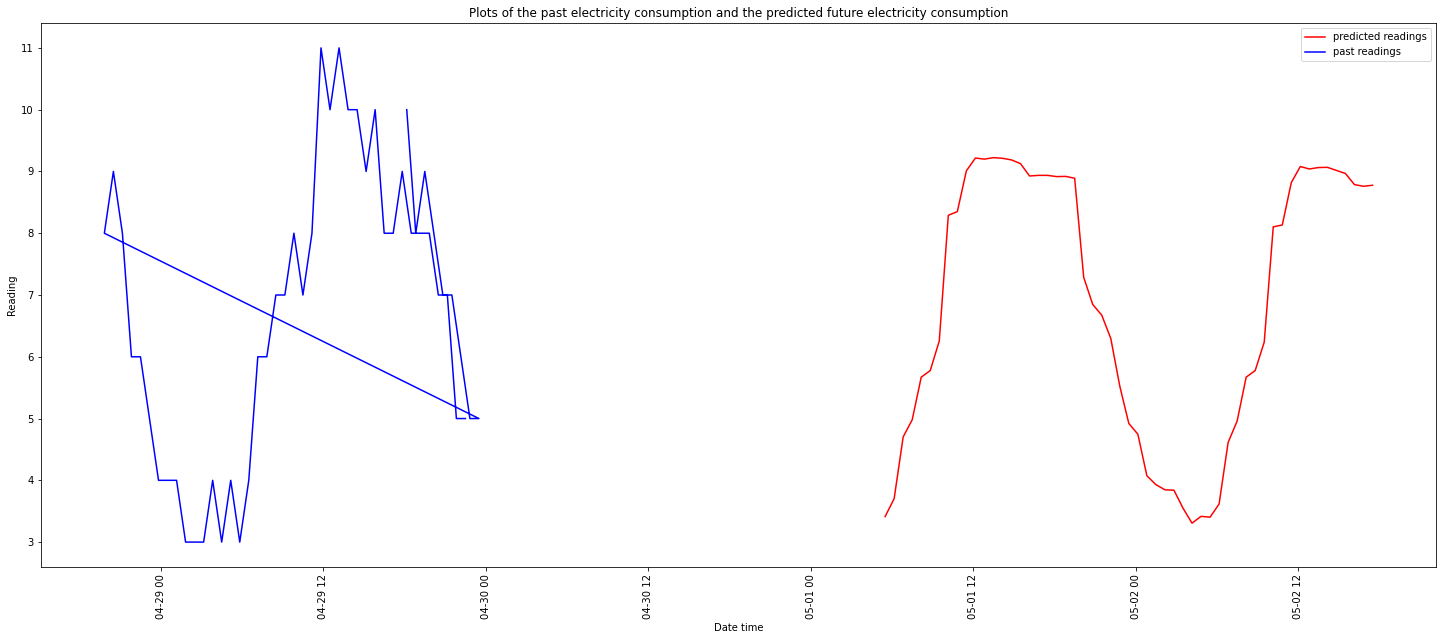

In [11]:
#import required libraries
import pandas as pd
import datetime
from datetime import datetime
start_predictions_timestamp=pd.to_datetime('2019-05-01 05:30:00') #define the timestamp that predictions are required to start from
prediction_interval=pd.to_timedelta('00:40:00') #define the intervals between predictions
end_predictions_timestamp=pd.to_datetime('2019-05-02 18:00:00')#define the timestamp of the last required prediction
synetica_data='synetica-apr-2019.zip' # provide the filename of the past data that will be used
meter_ID='MC062-L01/M7' #provide the meter ID of the meter that predictions are required for
building=' Bowland Twr (Old Bowland Annexe) '#provide the name of the building to acquire occupancy data 
check=False #set to True if the predictions can be checked by recorded data
check_data='synetica-may-2019.zip' #provide the filname of the data set containing the real recorded readings for the specified dates
predictions(synetica_data, meter_ID, building, start_predictions_timestamp, prediction_interval, 
            end_predictions_timestamp, check, check_data) #call the function